In [44]:
import numpy as np
import pandas as pd

In [45]:
# jupyter
train = pd.read_csv('./data01/train.csv/train.csv')
test = pd.read_csv('./data01/test.csv/test.csv')
submission = pd.read_csv('./data01/submission.csv')

# # colab
# from google.colab import drive
# drive.mount('/content/drive')
# train = pd.read_csv('/content/drive/MyDrive/kaggle-study/2/data01/train.csv/train.csv')
# test = pd.read_csv('/content/drive/MyDrive/kaggle-study/2/data01/test.csv/test.csv')
# submission = pd.read_csv('/content/drive/MyDrive/kaggle-study/2/data01/submission.csv')

In [46]:
# Dropped all columns except 'store_id', 'date', 'amount'
#
# The major reason for this was that the data does not include any hints on the type(clothing, food, alcohol, etc)
# of store and whether if the stores are similar types or not. Hence, removed them from both train & test.
train = train.drop(columns=['time', 'installments', 'days_of_week', 'card_id', 'holyday'])
test = test.drop(columns=['time', 'installments', 'days_of_week', 'card_id', 'holyday'])

In [47]:
train.head()

,store_id,date,amount
0,0,2016-12-14,5
1,0,2016-12-14,-5
2,0,2016-12-19,144
3,0,2016-12-19,66
4,0,2016-12-19,24


In [48]:
train.groupby(['date', 'store_id']).agg({'amount':'sum'})

amount
date       store_id        
2016-08-01 2           2372
           6           1080
           8           3650
           12          1155
           14          1270
...                     ...
2018-07-31 1794        3730
           1795        2427
           1796         230
           1797         900
           1798          80

[480160 rows x 1 columns]

In [49]:
# Aggregated data into the sum of amount per each day, per store_id.
train = train.groupby(['date', 'store_id']).agg({'amount':'sum'}).reset_index()
test = test.groupby(['date', 'store_id']).agg({'amount':'sum'}).reset_index()

In [50]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480160 entries, 0 to 480159
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   date      480160 non-null  object
 1   store_id  480160 non-null  int64 
 2   amount    480160 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 11.0+ MB


In [51]:
train.head()

,date,store_id,amount
0,2016-08-01,2,2372
1,2016-08-01,6,1080
2,2016-08-01,8,3650
3,2016-08-01,12,1155
4,2016-08-01,14,1270


In [52]:
# pandas to_datetime() 의 infer_datetime_format 매개변수에 따른 반환값 차이 확인
#infer_datetime_formatbool, default False
# If True and no format is given, attempt to infer the format of the datetime strings based on
# the first non-NaN element, and if it can be inferred, switch to a faster method of parsing them. 
# In some cases this can increase the parsing speed by ~5-10x.
pd.to_datetime(train['date'],infer_datetime_format=True)

0        2016-08-01
1        2016-08-01
2        2016-08-01
3        2016-08-01
4        2016-08-01
            ...    
480155   2018-07-31
480156   2018-07-31
480157   2018-07-31
480158   2018-07-31
480159   2018-07-31
Name: date, Length: 480160, dtype: datetime64[ns]

In [53]:
# 'date' column was converted into datetime format for further uses
train['date'] = pd.to_datetime(train['date'],infer_datetime_format=True)
test['date'] = pd.to_datetime(test['date'],infer_datetime_format=True)

In [54]:
# a duplicate column of 'date' was created for further uses
train['temp_date'] = train['date']
test['temp_date'] = test['date']

In [55]:
# the 'date' column was set to index
train.set_index("date",inplace=True)
test.set_index("date",inplace=True)

In [56]:
train.head()

,store_id,amount,temp_date
date,,,
2016-08-01,2,2372,2016-08-01
2016-08-01,6,1080,2016-08-01
2016-08-01,8,3650,2016-08-01
2016-08-01,12,1155,2016-08-01
2016-08-01,14,1270,2016-08-01


In [57]:
# 160일 이상의 데이터가 있는 가게만 포함.
# 가게 수는 많이 줄었지만, 전체 데이터는 크게 줄지 않았다
# -> 없어진 가게들이 적은 데이터를 가졌으므로
# Then, the number of data per each store_id in the train set was counted.
# If the store_id had less than 160 rows (= 160 days of data), it was removed from the train set.
#
# Since the goal of the 1st Competition was to predict the future 100 days of sales,
# 160 days was required to split into 60 days of training (X) & 100 days of prediction (y)
# The 'limit' 160 days was the ideal number resulted from multiple trials of training.
counter = 0
limit = 160

print("Before removing stores (due to limit): ", train.shape)

for x in range(train['store_id'].max()+1): # iterating through each store_id
    if train[train['store_id']==x]['store_id'].count() >= limit:
        counter += 1
    else:
        # drop rows that has total 'store_id' less than limit
        train = train[train.store_id != x]

print("Total # of stores that exceeds {} is {}".format(limit, counter))
print("After removing stores (due to limit): ", train.shape)

Before removing stores (due to limit):  (480160, 3)
Total # of stores that exceeds 160 is 997
After removing stores (due to limit):  (432671, 3)


In [58]:
# Now, the train set was checked for any stores that was out of business and removed them from the train set.
# If the store had no data within 5 days from 2018-07-31, it was 'assumed' to be closed.
# (2018-07-31 was the last date stores in train data was supposed to have)
from datetime import datetime

def keep_alive_store(df):
    
    store_id_list = df.store_id.unique() # list of train store_id
    yes, no = 0, 0 # yes: store has data within 5 days from 2018-07-31 / no: it doesn't

    t2 = datetime.strptime('2018-07-31 00:00:00', "%Y-%m-%d %H:%M:%S")

    for s in store_id_list:
        if str(df[df.store_id == s].iloc[-1]['temp_date']) == '2018-07-31 00:00:00':
            yes += 1
        else:
            # t1 is the last date of data the corresponding store_id has
            t1 = datetime.strptime(str(df[df.store_id == s].iloc[-1]['temp_date']), "%Y-%m-%d %H:%M:%S")
            difference = t2 - t1
            if difference.days <= 5:            
                yes +=1
            else:
                no +=1
                # 아래와 같이 원하지 않는 데이터 지울 수 있다.
                df = df[df.store_id != s] # remove stores that are 'assumed' closed
    print("# of train store open/out of business: ", yes, no)
    return df
    
train = keep_alive_store(train)

# of train store open/out of business:  906 91


In [59]:
datetime.strptime('2018-07-31 00:00:00', "%Y-%m-%d %H:%M:%S")

datetime.datetime(2018, 7, 31, 0, 0)

In [60]:
# The same goes for the test data, but in a slightly different way.
# If the store had no data within 7 days from 2018-03-31, it was 'assumed' to be closed.
# (2018-03-31 was the last date stores in test data was supposed to have)
store_id_list = test.store_id.unique() # list of test store_id
yes, no = 0, 0 # yes: store has data within 7 days from 2018-03-31 / no: it doesn't
closed_test_store = []

for s in store_id_list:
    t2 = datetime.strptime('2018-03-31 00:00:00', "%Y-%m-%d %H:%M:%S")
    t1 = datetime.strptime(str(test[test.store_id == s].iloc[-1]['temp_date']), "%Y-%m-%d %H:%M:%S")
    difference = t2 - t1
    
    if difference.days <= 7:
        yes+=1
    else:
        no+=1
        print(test[test.store_id == s].iloc[-1]['temp_date'])
        closed_test_store.append(s)
print("# of test store open/out of business: ", yes, no)
# Note that this time, closed stores were not dropped (obviously) and saved into 'closed_test_store' array.       

2018-03-21 00:00:00
2018-01-17 00:00:00
2018-03-23 00:00:00
2018-03-23 00:00:00
# of test store open/out of business:  196 4


In [61]:
# Finally, each train & test data was passed into 'reform_data(df, isTrain)'
# With each 'store_id' grouped into a new dataframe, any missing dates were filled with the amount 0
# Then bunch of new columns were added to prepare for training/predicting:
# such as the moving averages, y value(the future 100days), mean, median, sum, etc.
# But they will be returned as an array, then converted into a dataframe later.

def reform_data(df, isTrain):
    store_id_list = df.store_id.unique() # list of store_id
    x_array = [] # array to return

    for s in store_id_list: # iterate through each store_id
        store = df[df.store_id == s]
        
        # Filling missing dates with value of 0
        store = store.asfreq('D', fill_value=0)
        store['temp_date'] = store.index
        store['store_id'] = s
        
        # Moving Average columns were added
        store['MA7'] = store['amount'].rolling('7D').mean()
        store['MA15'] = store['amount'].rolling('15D').mean()
        store['MA30'] = store['amount'].rolling('30D').mean()

        # For the train dataframe, the last 100 days were cut off and the sum was stored as the 'y' value.
        # And the remaining data was stored into the dataframe 'store_x' to become the training data.
        if isTrain:
            store_y = store.last('100D') # last 100 days of store data
            y = store_y.amount.sum()
            store_x = store[store.temp_date < store_y.iloc[0].temp_date] # data except last 100 days
        # For the test dataframe, all data was kept as 'store_x'.
        # Of course the 'y' is 0 here because that's to be predicted later on.
        else:
            y = 0
            store_x = store[:]
            
        new_data = [] # array for each store's new data
        new_data.append(s) # store_id
        new_data.append(y) # total sum of last 100 days (answer)

        new_data.append(store_x.amount.mean()) # mean of amount
        new_data.append(store_x.amount.median()) # median of amount
        
        new_data.append(store_x.last('7D').amount.mean()) # mean of amount (last 7 days)
        new_data.append(store_x.last('15D').amount.mean()) # mean of amount (last 15 days)
        new_data.append(store_x.last('30D').amount.mean()) # mean of amount (last 30 days)
        
        new_data.append(store_x.last('7D').amount.median()) # median of amount (last 7 days)
        new_data.append(store_x.last('15D').amount.median()) # median of amount (last 15 days)
        new_data.append(store_x.last('30D').amount.median()) # median of amount (last 30 days)
        
        new_data.append(store_x.last('7D').amount.sum()) # sum of amount (last 7 days)
        new_data.append(store_x.last('15D').amount.sum()) # sum of amount (last 15 days)
        new_data.append(store_x.last('30D').amount.sum()) # sum of amount (last 30 days)
        
        new_data.append(store_x.last('7D').MA7.mean()) # mean of Moving Average of 7D (last 7 days)
        new_data.append(store_x.last('15D').MA7.mean()) # mean of Moving Average of 7D (last 15 days)
        new_data.append(store_x.last('30D').MA7.mean()) # mean of Moving Average of 7D (last 30 days)
        new_data.append(store_x.last('7D').MA15.mean()) # mean of Moving Average of 15D (last 7 days)
        new_data.append(store_x.last('15D').MA15.mean()) # mean of Moving Average of 15D (last 15 days)
        new_data.append(store_x.last('30D').MA15.mean()) # mean of Moving Average of 15D (last 30 days)
        new_data.append(store_x.last('7D').MA30.mean()) # mean of Moving Average of 30D (last 7 days)
        new_data.append(store_x.last('15D').MA30.mean()) # mean of Moving Average of 30D (last 15 days)
        new_data.append(store_x.last('30D').MA30.mean()) # mean of Moving Average of 30D (last 30 days)
        
        x_array.append(new_data) # Append the 'new_data' array in to 'x_array'
        
    return x_array

reformed_train = reform_data(train, True) # train data with new values
reformed_test = reform_data(test, False) # test data with new values

In [62]:
train.head()

,store_id,amount,temp_date
date,,,
2016-08-01,2,2372,2016-08-01
2016-08-01,6,1080,2016-08-01
2016-08-01,8,3650,2016-08-01
2016-08-01,12,1155,2016-08-01
2016-08-01,14,1270,2016-08-01


In [63]:
train.index

DatetimeIndex(['2016-08-01', '2016-08-01', '2016-08-01', '2016-08-01',
               '2016-08-01', '2016-08-01', '2016-08-01', '2016-08-01',
               '2016-08-01', '2016-08-01',
               ...
               '2018-07-31', '2018-07-31', '2018-07-31', '2018-07-31',
               '2018-07-31', '2018-07-31', '2018-07-31', '2018-07-31',
               '2018-07-31', '2018-07-31'],
              dtype='datetime64[ns]', name='date', length=400480, freq=None)

In [64]:
train[train.store_id==2].asfreq('D')

,store_id,amount,temp_date
date,,,
2016-08-01,2.0,2372.0,2016-08-01
2016-08-02,2.0,2075.0,2016-08-02
2016-08-03,2.0,2359.0,2016-08-03
2016-08-04,2.0,1720.0,2016-08-04
2016-08-05,2.0,1645.0,2016-08-05
...,...,...,...
2018-07-27,2.0,1757.0,2018-07-27
2018-07-28,2.0,1075.0,2018-07-28
2018-07-29,2.0,1770.0,2018-07-29


In [65]:
train[train.store_id==2]

,store_id,amount,temp_date
date,,,
2016-08-01,2,2372,2016-08-01
2016-08-02,2,2075,2016-08-02
2016-08-03,2,2359,2016-08-03
2016-08-04,2,1720,2016-08-04
2016-08-05,2,1645,2016-08-05
...,...,...,...
2018-07-27,2,1757,2018-07-27
2018-07-28,2,1075,2018-07-28
2018-07-29,2,1770,2018-07-29


In [66]:
asfreq_diff_index = list(set(train[train.store_id==2].asfreq('D').index)\
                         - set(train[train.store_id==2].index))

In [67]:
asfreq_diff_index

[Timestamp('2018-02-17 00:00:00', freq='D'),
 Timestamp('2018-02-16 00:00:00', freq='D'),
 Timestamp('2017-10-04 00:00:00', freq='D'),
 Timestamp('2017-10-05 00:00:00', freq='D'),
 Timestamp('2017-01-28 00:00:00', freq='D'),
 Timestamp('2018-02-18 00:00:00', freq='D'),
 Timestamp('2017-10-06 00:00:00', freq='D'),
 Timestamp('2016-09-15 00:00:00', freq='D')]

In [68]:
# 실행오류남 -> 해당 날짜 없음
# train[train.store_id==2].loc[asfreq_diff_index, :]

In [69]:
train[train.store_id==2].asfreq('D').loc[asfreq_diff_index, :]

,store_id,amount,temp_date
date,,,
2018-02-17,NaN,NaN,NaT
2018-02-16,NaN,NaN,NaT
2017-10-04,NaN,NaN,NaT
2017-10-05,NaN,NaN,NaT
2017-01-28,NaN,NaN,NaT
2018-02-18,NaN,NaN,NaT
2017-10-06,NaN,NaN,NaT
2016-09-15,NaN,NaN,NaT


In [70]:
train[train.store_id==2].asfreq('D', fill_value=0).loc[asfreq_diff_index, :]

,store_id,amount,temp_date
date,,,
2018-02-17,0,0,0
2018-02-16,0,0,0
2017-10-04,0,0,0
2017-10-05,0,0,0
2017-01-28,0,0,0
2018-02-18,0,0,0
2017-10-06,0,0,0
2016-09-15,0,0,0


In [71]:
train.last('100D')

,store_id,amount,temp_date
date,,,
2018-04-23,0,8053,2018-04-23
2018-04-23,2,1865,2018-04-23
2018-04-23,3,27,2018-04-23
2018-04-23,4,1230,2018-04-23
2018-04-23,6,310,2018-04-23
...,...,...,...
2018-07-31,1791,2808,2018-07-31
2018-07-31,1793,860,2018-07-31
2018-07-31,1794,3730,2018-07-31


In [72]:
# Now the returned array is back to its dataframe form with columns names.
# t => train / r_test => test
t = pd.DataFrame(reformed_train, columns=['store_id', 'y', 'mean', 'median', '7mean', '15mean', '30mean', 
                                         '7median', '15median', '30median',  '7sum', '15sum', '30sum', 
                                         '7ma7mean', '15ma7mean', '30ma7mean',  '7ma15mean', '15ma15mean',
                                         '30ma15mean',  '7ma30mean', '15ma30mean', '30ma30mean'])
r_test = pd.DataFrame(reformed_test, columns=['store_id', 'y', 'mean', 'median', '7mean', '15mean', '30mean', 
                                         '7median', '15median', '30median',  '7sum', '15sum', '30sum', 
                                         '7ma7mean', '15ma7mean', '30ma7mean',  '7ma15mean', '15ma15mean',
                                         '30ma15mean',  '7ma30mean', '15ma30mean', '30ma30mean'])

In [73]:
t.head()

,store_id,y,mean,median,7mean,15mean,30mean,7median,15median,30median,...,30sum,7ma7mean,15ma7mean,30ma7mean,7ma15mean,15ma15mean,30ma15mean,7ma30mean,15ma30mean,30ma30mean
0,2,186853,2266.995238,2267.0,2207.714286,2209.466667,2272.233333,2174.0,2174.0,2293.0,...,68167,2201.020408,2203.819048,2297.928571,2203.819048,2233.044444,2319.146667,2297.928571,2319.146667,2344.041111
1,6,219761,1857.495238,1080.0,2076.428571,2359.133333,1970.233333,1670.0,1670.0,1622.5,...,59107,2703.020408,2448.704762,2690.871429,2448.704762,2061.066667,2833.988889,2690.871429,2833.988889,3410.305556
2,8,79695,691.809524,500.0,623.571429,704.333333,650.666667,260.0,450.0,475.0,...,19520,570.102041,659.047619,591.166667,659.047619,635.622222,629.444444,591.166667,629.444444,664.450000
3,12,147744,1224.731746,898.5,1995.000000,1524.333333,1118.200000,2145.0,1155.0,990.0,...,33546,1772.346939,1273.571429,971.723810,1273.571429,990.880000,860.555556,971.723810,860.555556,824.680000
4,14,17253,309.682035,150.0,267.142857,218.733333,340.766667,195.0,187.0,153.5,...,10223,252.836735,471.485714,341.904762,471.485714,465.400000,346.037778,341.904762,346.037778,305.583333


In [74]:
# xgboost was used to train the model from train data.
# 'train_test_split' from sklearn was used to split the train data (t)
# into train/test with test_size as 0.1
import xgboost as xgb
from sklearn.model_selection import train_test_split

col = [i for i in t.columns if i not in ['store_id','y']]
y = 'y'

train_x, train_cv, y, y_cv = train_test_split(t[col],t[y], test_size=0.1, random_state=2018)

In [75]:
# The model was trained with xgboost parameters as shown below.
# Parameters were chosen after several trials of optimization.
#
# ('num_rounds' & 'early_stopping_rounds' were given relatively big numbers
# since the training doesn't take much computing power.)
def XGB_regressor(train_X, train_y, test_X, test_y, feature_names=None, seed_val=2018, num_rounds=3000):
    param = {}
    param['objective'] = 'reg:linear'
    param['eta'] = 0.05
    param['max_depth'] = 10
    # param['silent'] = 1 # 출력 메세지 확인해보기 위해 주석처리 
    param['eval_metric'] = 'mae'
    param['min_child_weight'] = 1
    param['subsample'] = 0.7
    param['colsample_bytree'] = 0.7
    param['seed'] = seed_val
    num_rounds = num_rounds

    plst = list(param.items())

    xgtrain = xgb.DMatrix(train_X, label=train_y)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=300)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)
        
    return model

In [76]:
# We now have the trained model!
model = XGB_regressor(train_X = train_x, train_y = y, test_X = train_cv, test_y = y_cv)

[20:04:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-mae:70736	test-mae:70969.4
Multiple eval metrics have been passed: 'test-mae' will be used for early stopping.

Will train until test-mae hasn't improved in 300 rounds.
[1]	train-mae:67466.9	test-mae:67839.3
[2]	train-mae:64360.5	test-mae:64749.1
[3]	train-mae:61335.7	test-mae:61840
[4]	train-mae:58528.9	test-mae:59157.8
[5]	train-mae:55881.6	test-mae:56558.5
[6]	train-mae:53206.3	test-mae:54212.1
[7]	train-mae:50742.2	test-mae:52047
[8]	train-mae:48370.5	test-mae:49897.3
[9]	train-mae:46172.1	test-mae:47855.8
[10]	train-mae:44135.1	test-mae:45928.4
[11]	train-mae:42137.9	test-mae:44137.5
[12]	train-mae:40301.7	test-mae:42435
[13]	train-mae:38499	test-mae:40716.3
[14]	train-mae:36786.7	test-mae:39311.2
[15]	train-mae:35176.6	test-mae:37837.8
[16]	train-mae:33584.3	test-mae:36350.8
[17]	train-mae:32142.9	test-mae:34886.4
[18]	train-mae:30759.5	test-mae:33697.6
[1

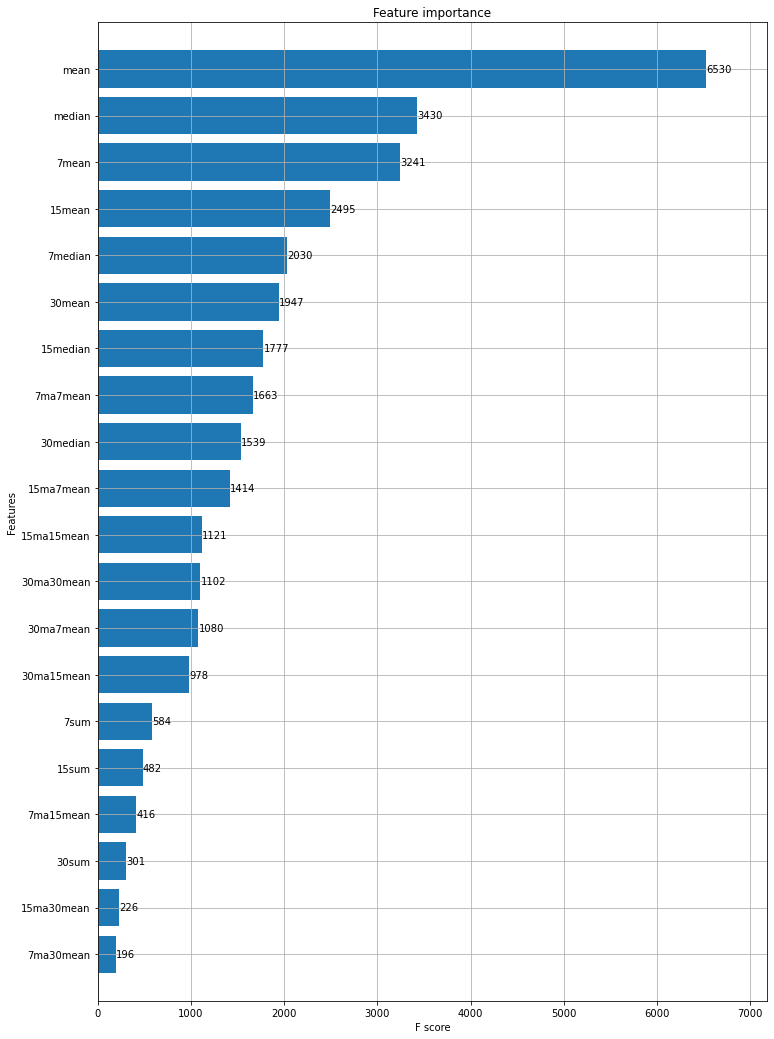

In [77]:
# (Optional) Feature Importance can be checked to see which column affected the model more.
# This was used for a quick check when optimizing columns.
from matplotlib import pylab as plt

fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

In [78]:
# The r_test (test dataset) has to be sorted since they are mixed at the moment.
r_test = r_test.sort_values(by='store_id')

In [79]:
# And then passed into the model to predict the answer for the competition as 'y_test'
# This is the answer array to be submitted... after a few adjustments.
y_test = model.predict(xgb.DMatrix(r_test[col]), ntree_limit = model.best_ntree_limit)

In [80]:
# As mentioned above the data may have missing dates in between.
# To reflect this into 'y_test', the last two months(february, march) of test data
# is counted per each store_id and then averaged out.
# This is required as some stores tend to be closed often throughout the month.
store_id_list = test.store_id.unique() # list of test store_id
store_id_list.sort() # sort the list into order

feb_march = [] # saved here

for s in store_id_list:
    mini = test[test.store_id == s]
    march = mini[mini.temp_date >= '2018-03-01']['temp_date'].count()
    feb = mini[mini.temp_date >= '2018-02-01']['temp_date'].count() - march
    feb_march.append((march+feb)/2/31)

In [81]:
# Before using the 'feb_march', the 'closed_test_store' array from above is used.
# The store_id 'assumed' to be closed are given 0 for the future 100 day prediction.
for c in closed_test_store:
    y_test[c] = 0

In [82]:
# At last the 'y_test' predicted from the trained model is adjusted with 'feb_march'.
#
# The last number 0.72 is an optimized number variable to make sure that no prediction exceeds the answer.
# This is required as penalties are given.
for x in range(200):
    y_test[x] = y_test[x] * feb_march[x] * 0.72

In [83]:
# For submission, the 'y_test' is saved into the 'total_sales' column of 'submission.csv'.
submission['total_sales'] = y_test
submission.to_csv('2_submission.csv', index=False)

점수: 34,396.61344